In [ ]:
#!pip3 install skimpy

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as se

from skimpy import skim
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Load data

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

Загрузим данные из base и target. Посмотрим как они выглядят, есть ли очень большие выбросы и т.д. 

## Base data

In [2]:
df_base = pd.read_csv("data/base.csv", index_col=0)
df_train = pd.read_csv("data/train.csv", index_col=0)

In [3]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
df_base.shape

(2918139, 72)

In [5]:
print("Количество уникальных индексов: ", len(df_base.index.unique()))

Количество уникальных индексов:  2918139


In [6]:
skim(df_base)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 2918139 │ │ float64     │ 72    │                                                         │
│ │ Number of columns │ 72      │ └─────────────┴───────┘                                                         │
│ └───────────────────┴─────────┘                                                                                 │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean     ┃ sd      ┃ p0       ┃ p25      ┃ p75    ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ 0                 │    0 │       0 │      -86 │      25 │     -200 │     -100 │    -69 │     22 │   ▁▇█▁   │  │
│ │ 1                 │    0 │       0 │      8.1 │       5 │      -14 │      4.7 │     11 │     30 │   ▁██▁   │  │
│ │ 2                 │    0 │       0 │      -45 │      39 │     -240 │      -70 │    -20 │    160 │    ▁█▇   │  │
│ │ 3                 │    0 │       0 │     -150 │      20 │     -230 │     -160 │   -130 │    -51 │   ▂█▆▁   │  │
│ │ 4                 │    0 │       0 │      110 │      46 │     -110 │       81 │    140 │    320 │   ▁▇█▁   │  │
│ │ 5                 │    0 │       0 │      -72 │      28 │     -210 │      -91 │    -52 │     59 │   ▁▇█▁   │  │
│ │ 6                 │    0 │       0 │     -390 │     270 │     -790 │     -630 │   -160 │    110 │  █▇▅▅▅▅  │  │
│ │ 7                 │    0 │       0 │       20 │      64 │     -300 │      -22 │     64 │    340 │   ▁██▁   │  │
│ │ 8                 │    0 │       0 │      120 │     6.4 │       93 │      120 │    130 │    150 │   ▁▆█▁   │  │
│ │ 9                 │    0 │       0 │      120 │      64 │     -170 │       82 │    170 │    430 │   ▁█▇▁   │  │
│ │ 10                │    0 │       0 │     -140 │      42 │     -340 │     -170 │   -110 │     41 │   ▁▆█▁   │  │
│ │ 11                │    0 │       0 │      -70 │      51 │     -370 │     -100 │    -36 │    180 │    ▄█▁   │  │
│ │ 12                │    0 │       0 │      -41 │      39 │     -230 │      -67 │    -15 │    120 │   ▁▅█▂   │  │
│ │ 13                │    0 │       0 │      7.6 │      37 │     -180 │      -17 │     33 │    180 │   ▁▆█▁   │  │
│ │ 14                │    0 │       0 │      150 │      34 │      -15 │      130 │    170 │    290 │    ▅█▂   │  │
│ │ 15                │    0 │       0 │      -23 │      13 │      -86 │      -32 │    -14 │     45 │    ▁█▆   │  │
│ │ 16                │    0 │       0 │    -0.94 │      21 │      -96 │      -15 │     13 │    110 │    ▁█▆   │  │
│ │ 17                │    0 │       0 │      -19 │      53 │     -270 │      -55 │     17 │    220 │   ▁▇█▁   │  │
│ │ 18                │    0 │       0 │     -140 │      47 │     -350 │     -170 │   -110 │     98 │   ▁█▆▁   │  │
│ │ 19                │    0 │       0 │      -79 │    0.76 │      -83 │      -80 │    -79 │    -76 │    ▅█▁   │  │
│ │ 20                │    0 │       0 │      -98 │      28 │     -240 │     -120 │    -79 │     32 │    ▅█▁   │  │
│ │ 21                │    0 │       0 │     1300 │     400 │      140 │     1100 │   1500 │   1600 │  ▁▁▁▁▁█  │  │
│ │ 22                │    0 │       0 │     -6.8 │     

## Train data

In [6]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [17]:
skim(df_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 100000 │ │ float64     │ 72    │                                                          │
│ │ Number of columns │ 73     │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0       ┃ p25      ┃ p75     ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ 0                 │    0 │       0 │     -85 │      26 │     -190 │     -100 │     -67 │     15 │   ▂██▂   │  │
│ │ 1                 │    0 │       0 │     7.7 │       5 │      -12 │      4.3 │      11 │     29 │   ▂█▆▁   │  │
│ │ 2                 │    0 │       0 │     -44 │      39 │     -220 │      -69 │     -18 │    130 │   ▁▆█▁   │  │
│ │ 3                 │    0 │       0 │    -150 │      20 │     -220 │     -160 │    -130 │    -61 │   ▂█▆▁   │  │
│ │ 4                 │    0 │       0 │     110 │      48 │      -93 │       79 │     140 │    300 │   ▁▆█▂   │  │
│ │ 5                 │    0 │       0 │     -73 │      29 │     -180 │      -93 │     -54 │     52 │   ▂█▆▁   │  │
│ │ 6                 │    0 │       0 │    -440 │     280 │     -790 │     -740 │    -200 │    110 │  █▅▃▃▃▃  │  │
│ │ 7                 │    0 │       0 │      21 │      66 │     -280 │      -22 │      66 │    290 │   ▁▆█▂   │  │
│ │ 8                 │    0 │       0 │     120 │     6.5 │       95 │      120 │     130 │    150 │   ▁▇█▂   │  │
│ │ 9                 │    0 │       0 │     130 │      65 │     -140 │       83 │     170 │    390 │   ▂██▂   │  │
│ │ 10                │    0 │       0 │    -140 │      42 │     -330 │     -170 │    -110 │     37 │   ▁▆█▁   │  │
│ │ 11                │    0 │       0 │     -69 │      51 │     -350 │     -100 │     -35 │    150 │    ▃█▂   │  │
│ │ 12                │    0 │       0 │     -43 │      41 │     -210 │      -70 │     -15 │    120 │   ▁▆█▂   │  │
│ │ 13                │    0 │       0 │     6.5 │      38 │     -150 │      -19 │      32 │    170 │   ▂█▇▁   │  │
│ │ 14                │    0 │       0 │     150 │      34 │      8.8 │      130 │     170 │    280 │   ▁▆█▂   │  │
│ │ 15                │    0 │       0 │     -24 │      13 │      -83 │      -32 │     -15 │     36 │   ▁██▁   │  │
│ │ 16                │    0 │       0 │    -2.2 │      21 │      -92 │      -16 │      12 │     94 │   ▂█▆▁   │  │
│ │ 17                │    0 │       0 │     -13 │      55 │     -250 │      -50 │      24 │    220 │   ▁▇█▂   │  │
│ │ 18                │    0 │       0 │    -140 │      49 │     -330 │     -170 │    -110 │     79 │   ▂█▅▁   │  │
│ │ 19                │    0 │       0 │     -79 │    0.78 │      -83 │      -80 │     -79 │    -76 │   ▁▇█▁   │  │
│ │ 20                │    0 │       0 │     -97 │      28 │     -230 │     -120 │     -79 │     26 │   ▁▆█▁   │  │
│ │ 21                │    0 │       0 │    1300 │     380 │      140 │     1200 │    1500 │   1600 │  ▁▁▁▁▁█  │  │
│ │ 22                │    0 │       0 │    -3.6 │      

## Validation data

In [10]:
df_validation = pd.read_csv("data/validation.csv", index_col=0)
df_validation_answer = pd.read_csv("data/validation_answer.csv", index_col=0)

In [11]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [12]:
df_validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


# Подготовка данных

## Оценка количества кластеров

Количесвто кластеров можно оценить с момощью Kmean и его встроенного отрибута *inertia_*, который считает сумму квадратов расстояний от образцов до центра их кластера. Получим зависимоть значений *inertia_* от количесвта кластеров, апроксимируем полученное соотношение. Далее найдем оптимельное количесвто класстеров, когда производная перестанет сильно изменяться. 

In [8]:
err = []
scale = StandardScaler() #масштабирование не влияет на оценку числа кластеров.
data_scaled = scale.fit_transform(df_base[:100000])
n_clusters = [10, 50, 100, 200, 500, 750, 1000]
for i in n_clusters:
    kmeans = KMeans(n_clusters = i, init='k-means++', n_init=5, random_state=42)
    kmeans.fit(data_scaled)
    print(kmeans.inertia_)
    err.append(kmeans.inertia_)

6613770.687102929
5707387.464792908
5217451.854151937
4794221.203287151
4326541.812452009
4138687.4218540997
4000710.6762939817


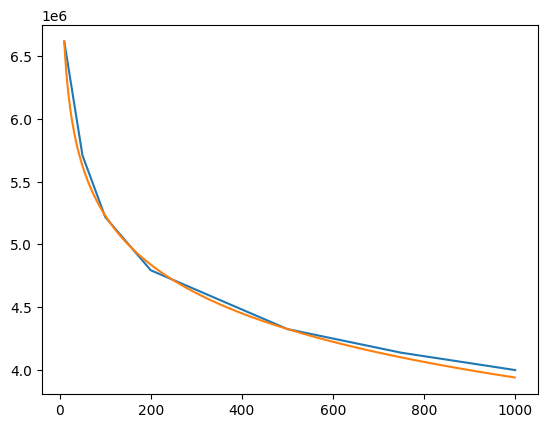

In [9]:
apoc_func = lambda x: 7.77509E6-5.55170662866E5*np.log(x-1.89531)
plt.plot(n_clusters, err, [i for i in range(10, 1000)], [apoc_func(i) for i in range(10, 1000)])

Посмотрим на производную от апроксимирующей функции 

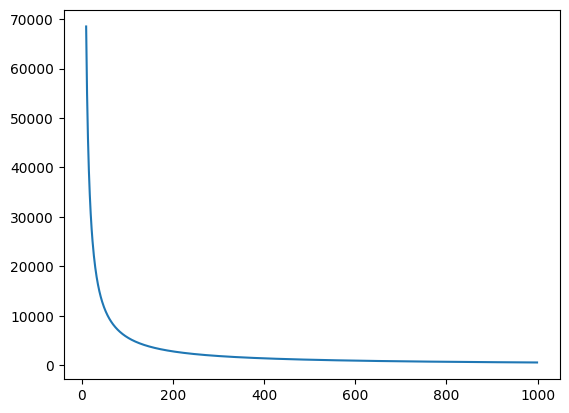

In [15]:
prime_func = lambda x: -5.55170662866E5/(x-1.89531)
plt.plot([i for i in range(10, 1000)], [abs(prime_func(i)) for i in range(10, 1000)])

Производная от ошибки слабо уменьшается после 150-200 кластеров

  0%|          | 0/13 [00:00<?, ?it/s]

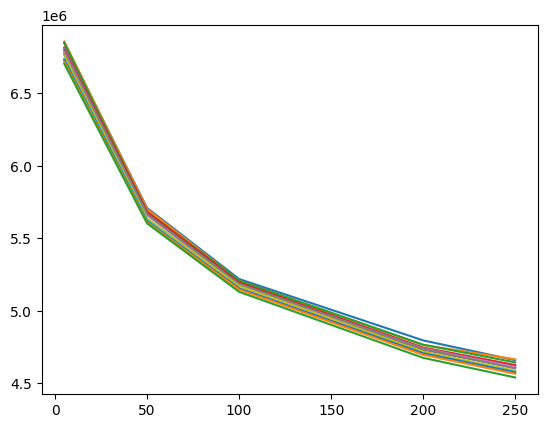

In [44]:
#Проверим ведет ли себя также ошибка на других частях датасета

sum_err = []
for j in tqdm(range((len(df_base)//100000)//2-1)):
    err = []
    scale = StandardScaler() 
    data_scaled = scale.fit_transform(df_base[100000*j*2:100000*(j*2+1)])
    n_clusters = [50, 100, 200, 250]
    for i in n_clusters:
        kmeans = KMeans(n_clusters = i, init='k-means++', n_init=5, random_state=42)
        kmeans.fit(data_scaled)
        err.append(kmeans.inertia_)
    plt.plot(n_clusters, err)
    sum_err.append(err)
plt.show()

*Вывод ячейки выше*
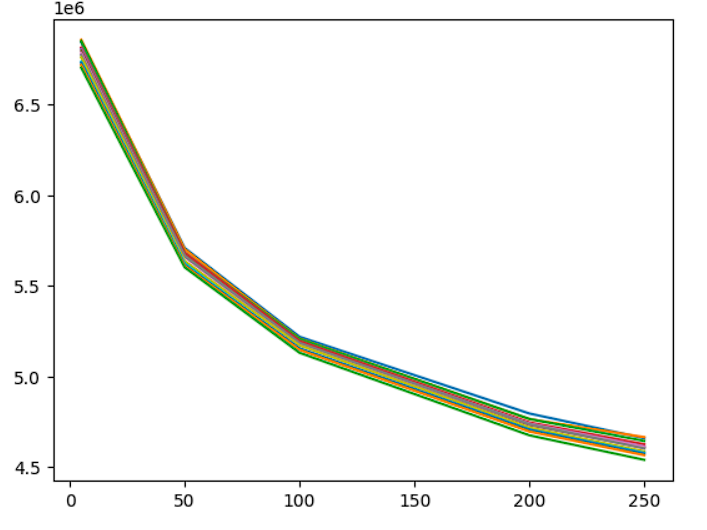

### Вывод

При значении 200, производная резко уменьшаться.

## Визуализация

In [16]:
kmeans = KMeans(n_clusters = 200)
cluster = kmeans.fit_predict(df_base[:100000])

In [18]:
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(df_base[:100000])

In [20]:
tsne2D_df = pd.DataFrame(data = tsne_data2D, columns=['x', 'y'])

In [21]:
tsne2D_df['cluster'] = cluster

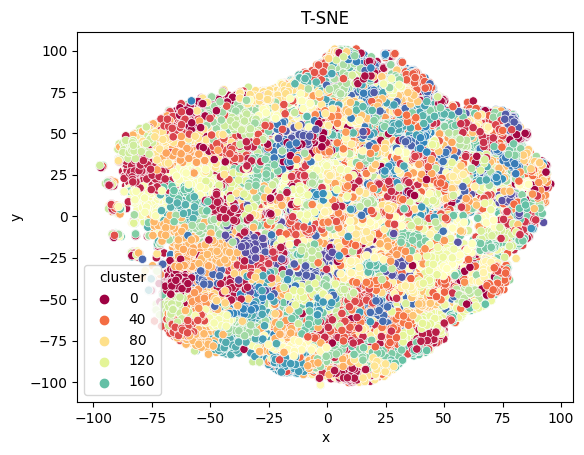

In [22]:
se.scatterplot(x='x', y='y',hue='cluster', data=tsne2D_df, palette="Spectral")
plt.title("T-SNE")
plt.show()

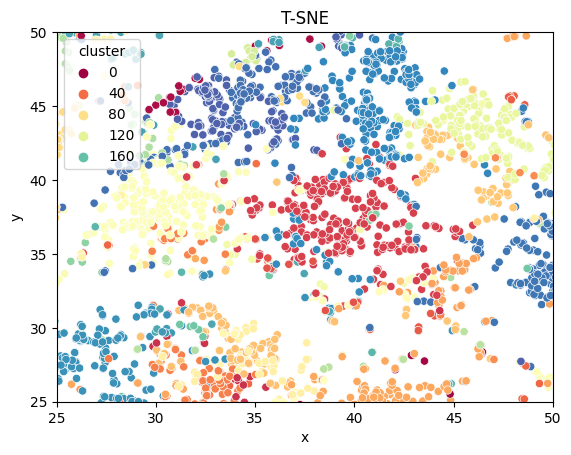

In [23]:
se.scatterplot(x='x', y='y',hue='cluster', data=tsne2D_df, palette="Spectral")
plt.title("T-SNE")
plt.xlim(25, 50)
plt.ylim(25, 50)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=tsne2D_df['x'], ys=tsne2D_df['y'], zs=tsne2D_df['z'])
plt.show()

# Обучение

## Nearest Neighbors (scikit-learn)

### Create index

In [73]:
dims = df_base.shape[1]
n_cells = 1000
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [74]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [75]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

In [70]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [76]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

In [77]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

4.351
